## Name :- Darpan Gaur
## Roll Number :- CO21BTECH11004

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time

import torch
from torchvision import datasets, transforms

from torch import nn, optim
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from sklearn.manifold import TSNE

In [2]:
# seed 
seed = 17
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# set device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [4]:
# load MINST dataset, train + test as dataset


# define a transform to normalize the data
transform_ = transforms.Compose([transforms.ToTensor()])

# download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform_)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform_)

BATCH_SIZE = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 256, latent_dim = 64, meanVar_dim = 2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )

        self.mean = nn.Linear(latent_dim, meanVar_dim)
        self.logvar = nn.Linear(latent_dim, meanVar_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(meanVar_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def encode(self, x):
        h = self.encoder(x)
        return self.mean(h), self.logvar(h)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
# Loss Function for VAE
def loss_function(x_in, x_out, mu, logvar):
    BCE = F.binary_cross_entropy(x_out, x_in, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
def train(EPOCHS, LR, model, optimizer, trainloader, output_dir='output'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # open log file
    log = open(f"{output_dir}/log.txt", "w")

    # set model to train mode
    model.train()

    best_loss = float('inf')

    start_time= time.time()

    # training loopx
    for epoch in tqdm(range(EPOCHS)):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            # print(inputs.shape)
            inputs = inputs.view(inputs.size(0), -1).to(device)
            # print(inputs.shape)

            optimizer.zero_grad()

            outputs, mu, logvar = model(inputs)
            loss = loss_function(inputs, outputs, mu, logvar)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader.dataset)}")
        log.write(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader.dataset)}\n")

        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), f"{output_dir}/best_model.pth")
    
    end_time = time.time()
    
    log.write(f"Training Time: {end_time-start_time}")

    torch.save(model.state_dict(), f"{output_dir}/last_model.pth")
    log.close()

In [7]:
LR = 1e-3
EPOCHS = 50
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

train(EPOCHS, LR, model, optimizer, trainloader, output_dir='output')

  2%|▏         | 1/50 [00:05<04:07,  5.06s/it]

Epoch 1, Loss: 219.372142578125


  4%|▍         | 2/50 [00:10<03:59,  4.99s/it]

Epoch 2, Loss: 174.03208860677083


  6%|▌         | 3/50 [00:15<04:01,  5.13s/it]

Epoch 3, Loss: 166.95884602864584


  8%|▊         | 4/50 [00:20<03:55,  5.12s/it]

Epoch 4, Loss: 163.3267604003906


 10%|█         | 5/50 [00:25<03:49,  5.10s/it]

Epoch 5, Loss: 160.09855631510416


 12%|█▏        | 6/50 [00:30<03:42,  5.05s/it]

Epoch 6, Loss: 157.6002612467448


 14%|█▍        | 7/50 [00:35<03:38,  5.08s/it]

Epoch 7, Loss: 155.6146410970052


 16%|█▌        | 8/50 [00:40<03:33,  5.08s/it]

Epoch 8, Loss: 153.86472189127605


 18%|█▊        | 9/50 [00:45<03:27,  5.06s/it]

Epoch 9, Loss: 152.39768245442707


 20%|██        | 10/50 [00:50<03:19,  4.98s/it]

Epoch 10, Loss: 151.20823727213542


 22%|██▏       | 11/50 [00:55<03:11,  4.90s/it]

Epoch 11, Loss: 150.0705049316406
Epoch 12, Loss: 149.18362649739584


 26%|██▌       | 13/50 [01:04<02:58,  4.82s/it]

Epoch 13, Loss: 148.2925587076823


 28%|██▊       | 14/50 [01:09<02:53,  4.81s/it]

Epoch 14, Loss: 147.66220618489584


 30%|███       | 15/50 [01:14<02:48,  4.82s/it]

Epoch 15, Loss: 147.23162890625


 32%|███▏      | 16/50 [01:19<02:45,  4.85s/it]

Epoch 16, Loss: 146.58257163085938


 34%|███▍      | 17/50 [01:24<02:40,  4.86s/it]

Epoch 17, Loss: 146.17125390625


 36%|███▌      | 18/50 [01:29<02:35,  4.87s/it]

Epoch 18, Loss: 145.68956560872397


 38%|███▊      | 19/50 [01:34<02:33,  4.94s/it]

Epoch 19, Loss: 145.33731346028645


 40%|████      | 20/50 [01:39<02:27,  4.93s/it]

Epoch 20, Loss: 144.96991075846356


 42%|████▏     | 21/50 [01:44<02:23,  4.95s/it]

Epoch 21, Loss: 144.75327989908854


 44%|████▍     | 22/50 [01:48<02:17,  4.93s/it]

Epoch 22, Loss: 144.2578796549479


 46%|████▌     | 23/50 [01:54<02:14,  4.99s/it]

Epoch 23, Loss: 143.97522643229166


 48%|████▊     | 24/50 [01:59<02:11,  5.04s/it]

Epoch 24, Loss: 143.77544711914064


 50%|█████     | 25/50 [02:04<02:06,  5.07s/it]

Epoch 25, Loss: 143.30924832356772


 52%|█████▏    | 26/50 [02:09<02:01,  5.05s/it]

Epoch 26, Loss: 142.91867486979166


 54%|█████▍    | 27/50 [02:14<01:55,  5.04s/it]

Epoch 27, Loss: 142.6778829264323


 56%|█████▌    | 28/50 [02:19<01:50,  5.03s/it]

Epoch 28, Loss: 142.50807797851562


 58%|█████▊    | 29/50 [02:24<01:45,  5.02s/it]

Epoch 29, Loss: 142.22975335286458


 60%|██████    | 30/50 [02:29<01:40,  5.04s/it]

Epoch 30, Loss: 141.9717819986979


 62%|██████▏   | 31/50 [02:34<01:35,  5.02s/it]

Epoch 31, Loss: 141.76992537434896


 64%|██████▍   | 32/50 [02:39<01:30,  5.00s/it]

Epoch 32, Loss: 141.5136457845052


 66%|██████▌   | 33/50 [02:44<01:24,  4.99s/it]

Epoch 33, Loss: 141.44951497395834


 68%|██████▊   | 34/50 [02:49<01:20,  5.00s/it]

Epoch 34, Loss: 141.13039817708332


 70%|███████   | 35/50 [02:54<01:13,  4.93s/it]

Epoch 35, Loss: 141.1305671061198


 72%|███████▏  | 36/50 [02:58<01:08,  4.89s/it]

Epoch 36, Loss: 141.08891586914064


 74%|███████▍  | 37/50 [03:03<01:03,  4.92s/it]

Epoch 37, Loss: 140.83381362304686


 76%|███████▌  | 38/50 [03:08<00:58,  4.87s/it]

Epoch 38, Loss: 140.75006822916666


 78%|███████▊  | 39/50 [03:13<00:53,  4.85s/it]

Epoch 39, Loss: 140.47678505859375


 80%|████████  | 40/50 [03:18<00:47,  4.78s/it]

Epoch 40, Loss: 140.3862064778646


 82%|████████▏ | 41/50 [03:22<00:42,  4.73s/it]

Epoch 41, Loss: 140.17383001302085


 84%|████████▍ | 42/50 [03:27<00:37,  4.68s/it]

Epoch 42, Loss: 140.18413118489585


 86%|████████▌ | 43/50 [03:31<00:32,  4.68s/it]

Epoch 43, Loss: 139.8886714029948


 88%|████████▊ | 44/50 [03:36<00:28,  4.70s/it]

Epoch 44, Loss: 139.85588499348958


 90%|█████████ | 45/50 [03:41<00:23,  4.73s/it]

Epoch 45, Loss: 139.7634683919271


 92%|█████████▏| 46/50 [03:46<00:18,  4.72s/it]

Epoch 46, Loss: 139.79371393229167


 94%|█████████▍| 47/50 [03:50<00:14,  4.74s/it]

Epoch 47, Loss: 139.72473037109376


 96%|█████████▌| 48/50 [03:56<00:09,  4.83s/it]

Epoch 48, Loss: 139.7457798828125


 98%|█████████▊| 49/50 [04:00<00:04,  4.80s/it]

Epoch 49, Loss: 139.69412117513022


100%|██████████| 50/50 [04:05<00:00,  4.91s/it]

Epoch 50, Loss: 139.53064331054688


## Que 2 (a)

- Encoder
    - Two linear layer with relu activation
    - 784 -> 256 -> 64

- Latent space
    - Linear layer to get mean and log variance
    - 64 -> 2

- Decoder
    - up sample the latent space to 64
    - Two linear layer with relu activation
    - 2 -> 64 -> 256 -> 784

## Que 2 (b)

In [8]:
# load model
model = VAE().to(device)
model.load_state_dict(torch.load('output/best_model.pth'))
model.eval()

print("Model loaded")

Model loaded


/tmp/ipykernel_3500080/1715765919.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('output/best_model.pth'))


In [9]:
# get embeddings for test images
def get_embeddings(model, testloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, lbl = data
            inputs = inputs.view(inputs.size(0), -1).to(device)
            outputs, mu, logvar = model(inputs)
            z = model.reparameterize(mu, logvar)
            embeddings.append(z)
            labels.append(lbl)

    return torch.cat(embeddings, dim=0), torch.cat(labels, dim=0)

embeddings, labels = get_embeddings(model, testloader)


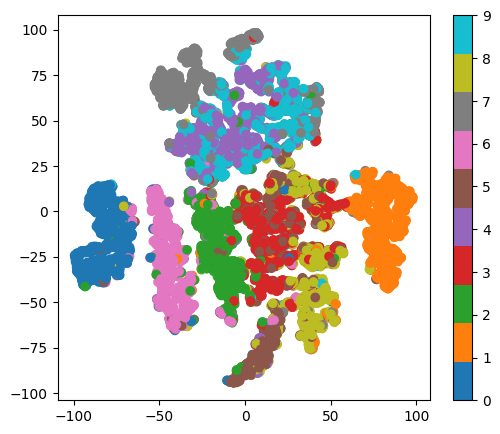

In [10]:
# TSNE plot of embeddings
def plot_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())
    # embeddings_2d = embeddings.cpu().numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.show()

plot_embeddings(embeddings, labels)

## Que 2 (c)

In [11]:
# load model
model = VAE().to(device)
model.load_state_dict(torch.load('output/best_model.pth'))
model.eval()

print("Model loaded")

Model loaded


/tmp/ipykernel_3500080/1715765919.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('output/best_model.pth'))


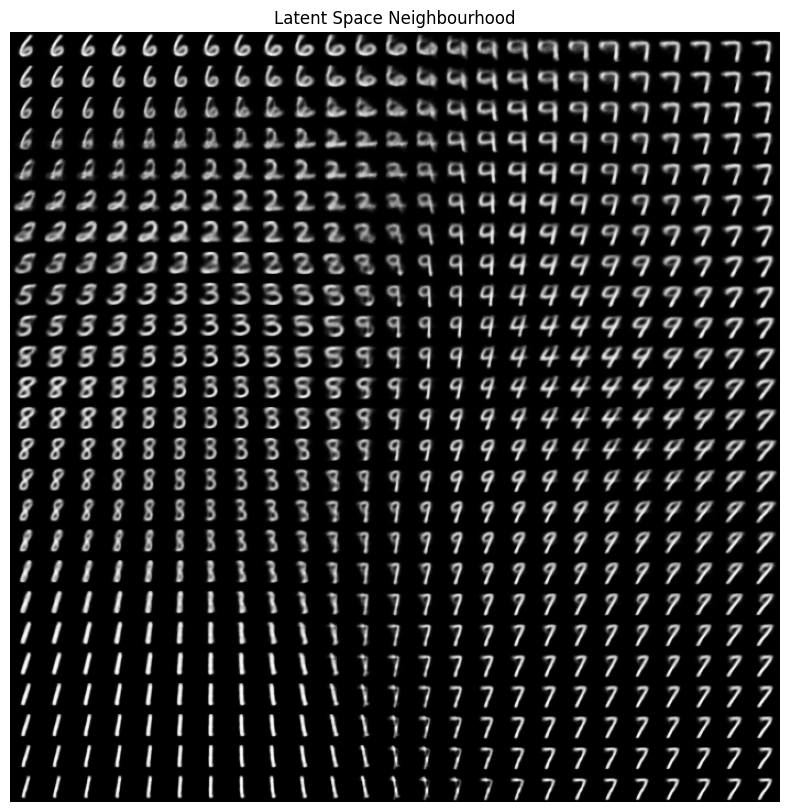

In [12]:
# plot nearby neighbors in latent space
def plotNeighborhood(model, initial, final, n=25):
    grid = np.zeros((28*n, 28*n))

    # construct grid
    x = np.linspace(initial, final, n)
    y = np.linspace(initial, final, n)

    for i, yi in enumerate(y):
        for j, xi in enumerate(x):
            z = torch.tensor([xi, yi], dtype=torch.float).to(device)
            output = model.decode(z)
            output = output.view(-1, 1, 28, 28)
            output = output.cpu().detach().numpy()
            grid[i*28:(i+1)*28, j*28:(j+1)*28] = output

    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title("Latent Space Neighbourhood")
    plt.show()

plotNeighborhood(model, -1, 2, n=25)

## Que 2 (d) 

- By seeing TSNE plot, we can see that the latent space is well separated and the clusters are formed. This shows that the model is able to learn the latent space and the latent space is well separated.
- Also the generated images are good and are able to generate the images similar to the input images. fig in que 2(c)
- By above results we can say the model has indeed learned to generate diverse samples of good quality.
- Tried FID score, but getting error, so not able to calculate the FID score.

## Que 3(a)


- VAE is a generative model that learns the latent space of the data and generates the data from the latent space, while DDPM model the data distribution by adding noise and learning revserse denoising process.
- Loss function of VAE is KL divergence while in DDPM it is MSE loss.
- VAE is a direct one-step generative model, while DDPM is a multi-step iterative model, which helps in generating better samples.

## Que 3(b)

- Refer sample output images for DDPM in `q2.ipynb` file, while for VAE above.
- DDPM generates better samples as compared to VAE, as it is a multi-step iterative model and learns the reverse denoising process, which helps in generating better samples.

## Que 3(c)

- Training time for models
    - VAE: 5sec per epoch
    - DDPM: 1min 20sec per epoch 
- Training time for VAE is less than DDPM, as VAE is a direct one-step generative model, while DDPM is a multi-step iterative model, which takes more time to train.
- Also DDPM has more parameters than VAE, which also increases the training time.